In [25]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import math
import os

class GramMatrix(nn.Module):
    def forward(self, y):
        (_, ch, h, w) = y.size()
        features = y.view(_, ch, w * h)
        gram = torch.bmm(features, features.transpose(1, 2)) / (ch * h * w)
        return gram

class CoMatch(nn.Module):
    def __init__(self, C):
        super(CoMatch, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, C, C), requires_grad=True)
        self.Gram = Variable(torch.Tensor(1, C, C), requires_grad=True)
        self.C = C
        self.reset_parameters()

    def reset_parameters(self):
        self.weight.data.uniform_(0.0, 0.02)

    def setTarget(self, target):
        self.Gram = target

    def forward(self, x):
        self.Q = torch.bmm(self.weight.expand_as(self.Gram), self.Gram)
        matching =  torch.bmm(self.Q.transpose(1, 2).expand(x.size(0), self.C, self.C), x.view(x.size(0), x.size(1), -1)).view_as(x)
        return matching 

    def __repr__(self):
        return self.__class__.__name__ + '(' + 'N x ' + str(self.C) + ')'

class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = (math.floor(kernel_size/2))
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class UpsampleConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        self.reflection_padding = (math.floor(kernel_size/2))
        if self.reflection_padding != 0:
            self.reflection_pad = nn.ReflectionPad2d(self.reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = self.upsample_layer(x)
        if self.reflection_padding != 0:
            x = self.reflection_pad(x)
        out = self.conv2d(x)
        return out


class Bottleneck(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.expansion = 4
        self.downsample = downsample
        if self.downsample is not None:
            self.residual_layer = nn.Conv2d(inplanes, planes*self.expansion,
                                            kernel_size=1, stride=stride)
        self.conv_block = nn.Sequential(nn.BatchNorm2d(inplanes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(inplanes, planes, kernel_size=1, stride=1),
                       nn.BatchNorm2d(planes),
                       nn.ReLU(inplace=True),
                       ConvLayer(planes, planes, kernel_size=3, stride=stride),
                       nn.BatchNorm2d(planes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(planes, planes*self.expansion, kernel_size=1,stride=1))
        
    def forward(self, x):
        if self.downsample is None:
            residual = x
        else:
            residual = self.residual_layer(x)       
        out = self.conv_block(x)
        final = out + residual
        return final 

class ResidualBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=2):
        super(ResidualBlock, self).__init__()
        self.expansion = 4
        self.residual_layer = UpsampleConvLayer(inplanes, planes*self.expansion,
                                                kernel_size=1, stride=1,
                                                upsample=stride)
        
        self.conv_block = nn.Sequential(nn.BatchNorm2d(inplanes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(inplanes, planes, kernel_size=1, stride=1),
                       nn.BatchNorm2d(planes),
                       nn.ReLU(inplace=True),
                       UpsampleConvLayer(planes, planes, kernel_size=3, stride=1, upsample=stride),
                       nn.BatchNorm2d(planes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(planes, planes*self.expansion, kernel_size=1,stride=1))
            
    def forward(self, x):
        return self.conv_block(x) + self.residual_layer(x)

class Net(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64,
                 n_blocks=6):
        super(Net, self).__init__()
        self.Gram = GramMatrix()
        block = Bottleneck
        upblock = ResidualBlock
        expansion = 4

        self.siamese = nn.Sequential(ConvLayer(input_nc, 64, kernel_size=7, stride=1),
                   nn.BatchNorm2d(64),
                   nn.ReLU(inplace=True),
                   block(64, 32, 2, 1),
                   block(32*expansion, ngf, 2, 1))

        self.ins = CoMatch(ngf*expansion)
        model = [self.siamese]
        model += [self.ins]

        for i in range(n_blocks):
            model += [block(ngf*expansion, ngf, 1, None)]

        model += [upblock(ngf*expansion, 32, 2),
                  upblock(32*expansion, 16, 2),
                  nn.BatchNorm2d(16*expansion),
                  nn.ReLU(inplace=True),
                  ConvLayer(16*expansion, output_nc, kernel_size=7, stride=1)]

        self.model = nn.Sequential(*model)

    def setTarget(self, Xs):
        f = self.siamese(Xs)
        G = self.Gram(f)
        self.ins.setTarget(G)

    def forward(self, input):
        return self.model(input)

- Implement utils functions for read/write image

In [26]:
from PIL import Image


def tensor_load_rgbimage(filename, size=None):
    img = Image.open(filename).convert('RGB')
    img = img.resize((size, size), Image.ANTIALIAS)
    img = np.array(img).transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    return img


def tensor_save_rgbimage(tensor, filename, cuda=False):
    if cuda:
        img = tensor.clone().cpu().clamp(0, 255).numpy()
    else:
        img = tensor.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    img.save(filename)


def tensor_save_bgrimage(tensor, filename, cuda=False):
    (b, g, r) = torch.chunk(tensor, 3)
    tensor = torch.cat((r, g, b))
    tensor_save_rgbimage(tensor, filename, cuda)


def preprocess_batch(batch):
    batch = batch.transpose(0, 1)
    (r, g, b) = torch.chunk(batch, 3)
    batch = torch.cat((b, g, r))
    batch = batch.transpose(0, 1)
    return batch

In [27]:
#this code has been directly taken from https://github.com/zhanghang1989/PyTorch-Multi-Style-Transfer

!wget -q -O 21styles.model https://www.dropbox.com/s/2iz8orqqubrfrpo/21styles.model?dl=1
style_model = Net(ngf=128)
model_dict = torch.load('21styles.model')
model_dict_clone = model_dict.copy()
for key, value in model_dict_clone.items():
    if key.endswith(('running_mean', 'running_var')):
        del model_dict[key]
style_model.load_state_dict(model_dict, False)

_IncompatibleKeys(missing_keys=['siamese.0.conv2d.weight', 'siamese.0.conv2d.bias', 'siamese.1.weight', 'siamese.1.bias', 'siamese.1.running_mean', 'siamese.1.running_var', 'siamese.3.residual_layer.weight', 'siamese.3.residual_layer.bias', 'siamese.3.conv_block.0.weight', 'siamese.3.conv_block.0.bias', 'siamese.3.conv_block.0.running_mean', 'siamese.3.conv_block.0.running_var', 'siamese.3.conv_block.2.weight', 'siamese.3.conv_block.2.bias', 'siamese.3.conv_block.3.weight', 'siamese.3.conv_block.3.bias', 'siamese.3.conv_block.3.running_mean', 'siamese.3.conv_block.3.running_var', 'siamese.3.conv_block.5.conv2d.weight', 'siamese.3.conv_block.5.conv2d.bias', 'siamese.3.conv_block.6.weight', 'siamese.3.conv_block.6.bias', 'siamese.3.conv_block.6.running_mean', 'siamese.3.conv_block.6.running_var', 'siamese.3.conv_block.8.weight', 'siamese.3.conv_block.8.bias', 'siamese.4.residual_layer.weight', 'siamese.4.residual_layer.bias', 'siamese.4.conv_block.0.weight', 'siamese.4.conv_block.0.bias'

In [28]:
content_image = tensor_load_rgbimage('st.jpg', size=512).unsqueeze(0)
style_image = tensor_load_rgbimage('mosaicc.jpg', size=512).unsqueeze(0)
style_image = preprocess_batch(style_image)

- Set the style target and generate outputs

In [29]:
namesaved = 'final3.jpg'
style_v = Variable(style_image)
content_image = Variable(preprocess_batch(content_image))
style_model.setTarget(style_v)
#print(content_image)
output = style_model(content_image)
tensor_save_bgrimage(output.data[0], namesaved)

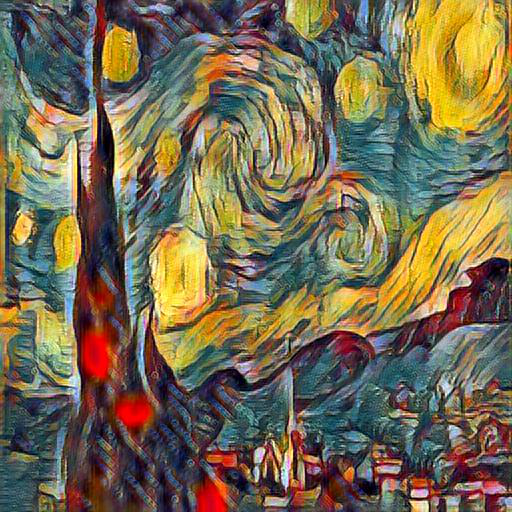

In [30]:
display(Image.open(namesaved))

In [31]:
style_pics = ["Composition", "nude", "Scream", "Shipwreck_turner","simple","st","sunrise","yellow"]
content_pics = ["ballet", "chapel", "df", "face", "house", "landscape", "Taj", "tsunami"]
for i in range(len(style_pics)):
    for j in range(len(content_pics)):
        if (content_pics[j] == "Taj"):
            content_image = tensor_load_rgbimage('content/'+str(content_pics[j])+'.jpeg', size=512).unsqueeze(0)
        else:
            content_image = tensor_load_rgbimage('content/'+str(content_pics[j])+'.jpg', size=512).unsqueeze(0)
        if (style_pics[i] == "nude"):
            style_image = tensor_load_rgbimage('style/'+str(style_pics[i])+'.jpeg', size=512).unsqueeze(0)
        else:
            style_image = tensor_load_rgbimage('style/'+str(style_pics[i])+'.jpg', size=512).unsqueeze(0)
        style_image = preprocess_batch(style_image)
        
        style_model = Net(ngf=128)
        model_dict = torch.load('21styles.model')
        model_dict_clone = model_dict.copy()
        for key, value in model_dict_clone.items():
            if key.endswith(('running_mean', 'running_var')):
                del model_dict[key]
        style_model.load_state_dict(model_dict, False)
    
        style_v = Variable(style_image)
        content_image = Variable(preprocess_batch(content_image))
        style_model.setTarget(style_v)
        output = style_model(content_image)
        tensor_save_bgrimage(output.data[0], 'output/'+str(content_pics[j])+'_'+str(style_pics[i])+'.jpg', False)

KeyboardInterrupt: 

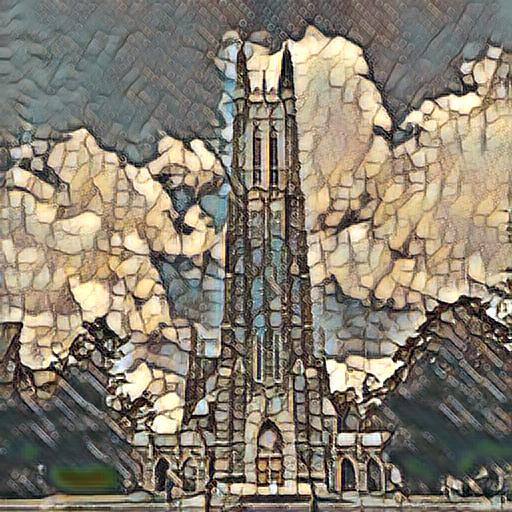

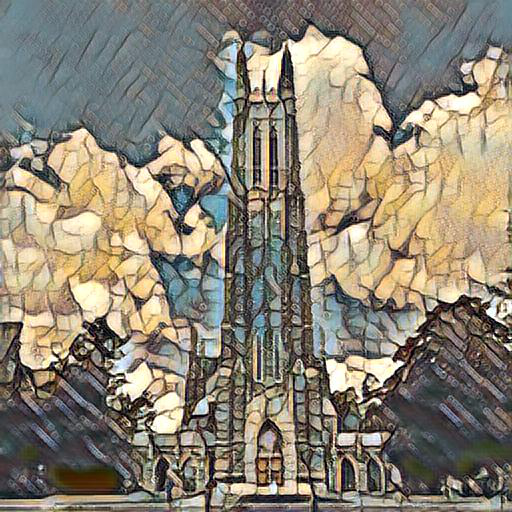

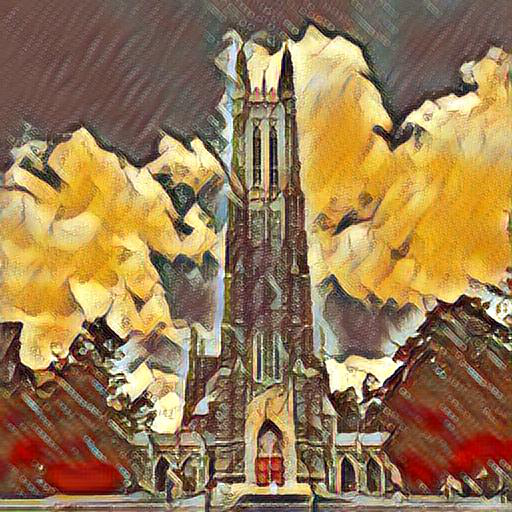

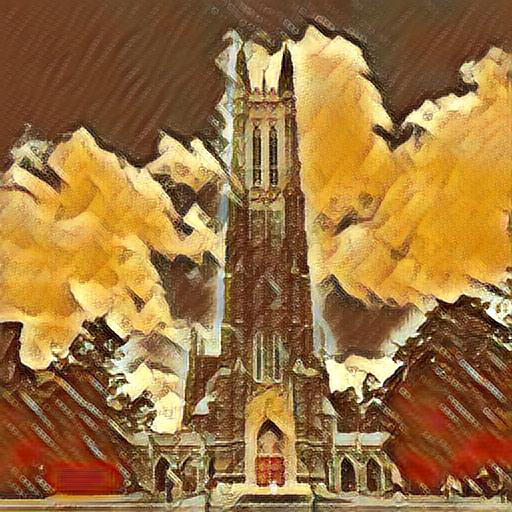

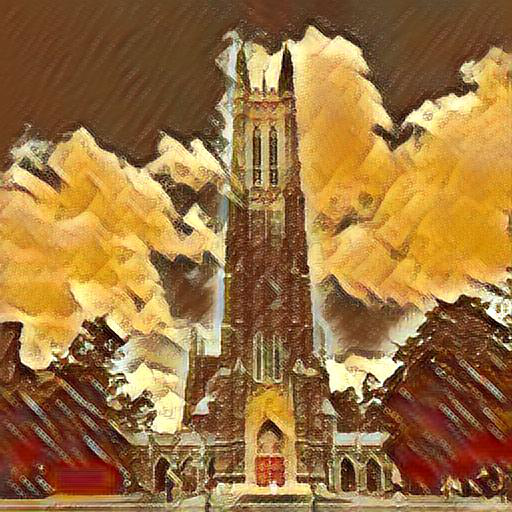

In [32]:
sizes_list =  [64, 128, 256, 512, 1024]
for i in range(len(sizes_list)):
    content_image = tensor_load_rgbimage('chapel.jpg', size=512).unsqueeze(0)
    style_image = tensor_load_rgbimage('Composition.jpg', size = sizes_list[i]).unsqueeze(0)
    style_image = preprocess_batch(style_image)
    style_model = Net(ngf=128)
    model_dict = torch.load('21styles.model')
    model_dict_clone = model_dict.copy()
    for key, value in model_dict_clone.items():
        if key.endswith(('running_mean', 'running_var')):
            del model_dict[key]
    style_model.load_state_dict(model_dict, False)
    namesaved = 'brushsize_' + str(i) + '.jpg'
    style_v = Variable(style_image)
    content_image = Variable(preprocess_batch(content_image))
    style_model.setTarget(style_v)
    output = style_model(content_image)
    tensor_save_bgrimage(output.data[0], namesaved)
    display(Image.open(namesaved))